# pressure

this notebook annotates high and low pressure centers. the algorithm:

1) find the max pressure (or height)
2) annotate it with an H
3) mask out a 300km circle around it
4) select the maximum value again
5) if the maximum value is almost exactly 300km from the previous value, discard it and expand the circle a further 300km
6) if the maximum is a new local max, mark it with an H
7) terminate after n=10 ish
8) repeat for low pressure centers, marking them with L's

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
now = pd.Timestamp.utcnow().floor("6h").tz_localize(None)

In [3]:
ds = get_var(now, "gdps", 3, "PRMSL", "MSL_0")
ds["prmsl"] /= 100

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-15 12:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


In [220]:
pres = np.array(ds.prmsl)
radius = 90  # pixels
aspect = pres.shape[1] / pres.shape[0]

# generate the figure
fig, ax = plt.subplots()
ax.set_xticks(ticks=[], labels=([]))
ax.set_yticks(ticks=[], labels=([]))

# get the index of the max value
ymax, xmax = np.unravel_index(np.nanargmax(pres), pres.shape)

# mask out all values within radius of the max
x = np.arange(0, np.shape(pres)[1])
y = np.arange(0, np.shape(pres)[0])
mask = ((x[np.newaxis, :] - xmax) / aspect) ** 2 + (
    (y[:, np.newaxis] - ymax)
) ** 2 < radius**2
pres[mask] = np.nan
ax.text(xmax, ymax, "H", ha="center", va="center")

# repeat the operation
# get the index of the max value
ymax, xmax = np.unravel_index(np.nanargmax(pres), pres.shape)
ax.text(xmax, ymax, "H", ha="center", va="center")

mask = ((x[np.newaxis, :] - xmax) / aspect) ** 2 + (
    (y[:, np.newaxis] - ymax)
) ** 2 < radius**2
pres[mask] = np.nan

ValueError: Image size of 151311x24050 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

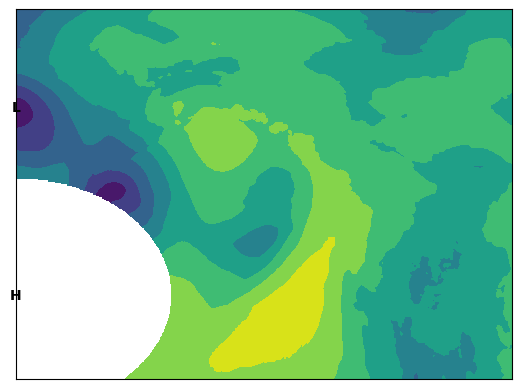

In [209]:
plt.contourf(pres)
plt.text(xmax, ymax, "H", ha="center", va="center")
plt.text(xmin, ymin, "L", ha="center", va="center")
plt.xticks(ticks=[], labels=([]))
plt.yticks(ticks=[], labels=([]));

In [122]:
np.unravel_index(pres.argmax(), pres.shape)

(np.int64(52), np.int64(254))

In [131]:
pres.shape

(287, 554)

In [184]:
aspect = pres.shape[1] / pres.shape[0]

1.9303135888501741

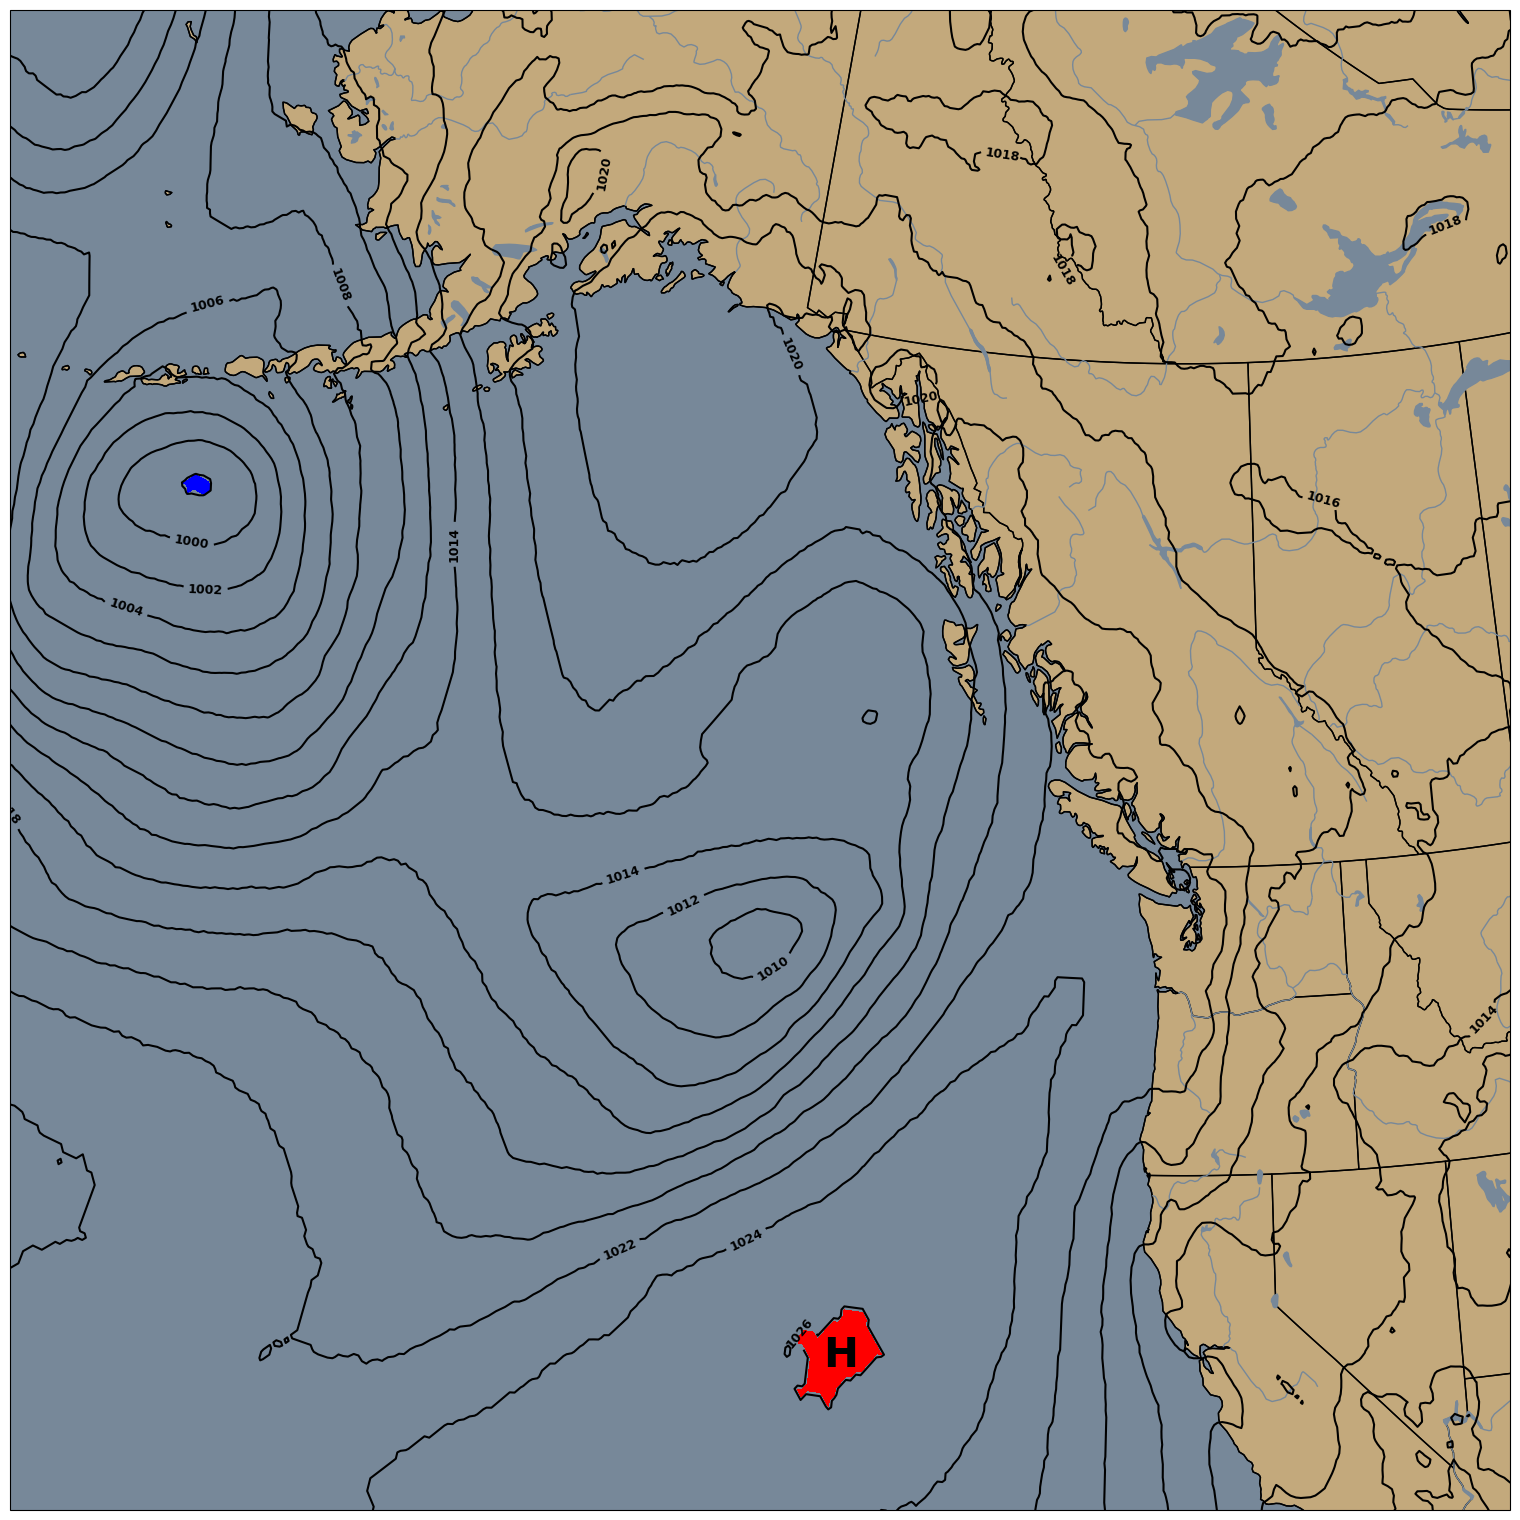

In [17]:
fig, ax = make_figure(extent="MWF")
# plot height contours
ht = ax.contour(
    ds.longitude,
    ds.latitude,
    pres,
    colors="k",
    transform=pc,
    levels=range(900, 1100, 2),
)
ax.clabel(ht, inline=True, fontsize=9)

mx = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.prmsl.where(ds.prmsl > 1026),
    colors="red",
    transform=pc,
)

mn = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.prmsl.where(ds.prmsl < 998),
    colors="blue",
    transform=pc,
)


ax.text(ds.longitude[303], ds.latitude[47], "H", size=30, transform=pc)

fig.show()